# Assignment 10

### 1.复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

### 2.回答以下理论题目?

#### 1. Compared to FNN, what is the biggest advantage of CNN?

权值共享。
多卷积核。
Pooling（下采样）。

#### 2. Suppose your input is a 100 by 100 gray image, and you use a convolutional layer with 50 filters that are each 5x5. How many parameters does this hidden layer have (including the bias parameters)? 

(5 * 5 * 1 +1)*50 = 1300

#### 3. What are "local invariant" and "parameter sharing" ?

局部不变特征是从图像的局部结构出发，利用局部信息构造出具有几何不变性和光照不变性的描述子。

参数共享（parameter sharing）是指在一个模型的多个函数中使用相同的参数。在传统的神经网络中，当计算一层的输出时，权重矩阵的每一个元素只使用一次，当
它乘以输入的一个元素后就再也不会用到了。

#### 4. Why we use batch normalization ?

BN就是通过一定的规范化手段，把每层神经网络任意神经元　这个输入值的分布强行拉回到均值为0方差为1的标准正态分布
使得非线性变换函数的输入值落入对输入比较敏感的区域，从而避免梯度消失问题。这样输入的小变化就会导致损失函数较大的变化（使得梯度变大，避免梯度消失问题产生），同时也让收敛速度更快，加快训练速度。


这个方法给每层的输出都做一次归一化（网络上相当于加了一个线性变换层），使得下一层的输入接近高斯分布。这个方法相当于下一层的w训练时避免了其输入以偏概全，因而泛化效果非常好。

#### 5. What problem does dropout try to solve ?

Dropout指的就是在神经网络的训练过程中提出的一种防止过拟合的策略。

#### 6.  Is the following statement correct and why ? "Because pooling layers do not have parameters, they do not affect  the backpropagation(derivatives) calculation"

错。由卷积层->池化层作为一个layer，在前向传播过程中，池化层里保存着卷积层的各个部分的最大值/平均值，然后由池化层传递给下一层，在反向传播过程中，由下一层传递梯度过来，“不影响反向传播的计算”这意味着池化层到卷积层（反向）没有梯度变化，梯度值就为0，既然梯度值为0，那么例如在$$ W^{[l]} = W^{[l]}−α×dW^{[l]}$$ 的过程中，参数 $W^{[l]}=W^{[l]}−α×0$，也就是说它不再更新，那么反向传播到此中断。所以池化层会影响反向传播的计算。




### 3. 实践题

#### 3.1 In the first session of the practical part, you will implement an image classification model using any deep learning libraries that you are familiar with,  which means, except for tensorflow and keras, you can also use pytorch/caffe/... .  The dataset used in this session is the cifar10 which contains 50000 color (RGB) images, each with size 32x32x3.  All 50000 images are classified into ten categories. 

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import utils, datasets, layers, models
import numpy as np
import os
import math

Load the dataset. 

In [3]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


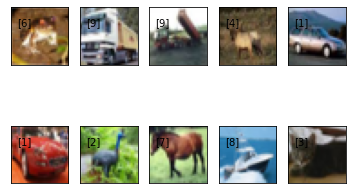

In [4]:
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(x_train[i-1])
    plt.text(3,10,str(y_train[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

##### It is your time to build your model. Try your best to build a model with good performance on the test set.

In [6]:
# normalize inputs from 0-255 to 0.0-1.0
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
X_train = x_train / 255.0
X_test = x_test / 255.0

In [7]:
# convert class vectors to binary vectors
Y_train = utils.to_categorical(y_train)
Y_test = utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


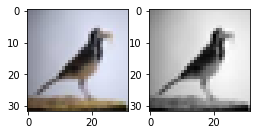

In [8]:
# transform a 3-channel image into one channel
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# plot a randomly chosen image
img = round(np.random.rand() * X_train.shape[0])
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(
    X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

In [9]:
def getHOGfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy, sz = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = np.zeros((sx, sy), dtype=np.double)
    gy = np.zeros((sx, sy), dtype=np.double)
    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.double)
    for i in range(1, sx - 1):
        for j in range(1, sy - 1):
            gx[i, j] = image[i, j - 1] - image[i, j + 1]
            gy[i, j] = image[i + 1, j] - image[i - 1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
            hist_block = np.zeros(32, dtype=np.double)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
                    hist_cell = np.zeros(8, dtype=np.double)
                    for i in range(cy):
                        for j in range(cx):
                            n = int(cell[i, j, 0] / 45)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(
                hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel()

In [10]:
X_train_hog = []
X_test_hog = []

print('This will take some minutes.')

for img in X_train_gray:
    img_hog = getHOGfeat(img)
    X_train_hog.append(img_hog)

for img in X_test_gray:
    img_hog = getHOGfeat(img)
    X_test_hog.append(img_hog)

X_train_hog_array = np.asarray(X_train_hog)
X_test_hog_array = np.asarray(X_test_hog)

This will take some minutes.


In [11]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model = models.Sequential()
model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())
                
model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(layers.BatchNormalization())
                
model.add(layers.Flatten())
model.add(layers.Dense(384, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(192, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=25,validation_data=(X_test, y_test),verbose=0)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [13]:
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy : %.4f'%test_acc)

Testing Accuracy : 0.7715


### 4. Optional 

##### Do you want to build a CNN from scratch ? 

In this optianl part, you will build a cnn network step by step.

In [14]:
import numpy as np
np.random.seed(1)

##### 4.1 Implement a convolution step

Hints: Numpy.sum function might be useful.

In [15]:
def conv_single_step(a_slice_prev,W,b):
    '''
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    Arguments:
    a_prev_slice: slice of input data (shape=(f,f,n_C_prev))
    W: Weight parameters contained in a window. (shape = (f,f,n_C_prev))
    b: Bias parameters contained in a window. (shape=(1,1,1))
    
    Reutrns:
    
    Z: a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data 
    '''
    # Element-wise product
    s = np.multiply(a_slice_prev, W)
    
    # Sum over s  
    Z = np.sum(s)
    
    # Add bias b to z.
    Z = Z + b.astype(float)
    
    return Z

In [16]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = [[[-6.99908945]]]


Use the code above to test your code. If your c
ode is correct, you should be able to get the output shown as below.

<table>
    <tr>
        <td>
            Z
        </td>
        <td>
            -6.99908945068
        </td>
    </tr>

</table>

##### 4.2 Padding

Hints: Numpy.pad function might be useful.

In [17]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad: integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """

    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    
    return X_pad

In [18]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
```

##### 4.3 Implement a forward propagation in CNN.

Hints: The formulas to calculate the output shapes are :

$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

In [19]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev: output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W: Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b: Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters: python dictionary containing "stride" and "pad"
        
    Returns:
    Z: conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache: cache of values needed for the conv_backward() function
    """
    
    # Get dimensions from A_prev's shape  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get dimensions from W's shape 
    (f, f, n_C_prev, n_C) = W.shape
    
    # Get information from "hparameters" 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. 
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros([m, n_H, n_W, n_C])
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i,:,:,:]                              # Select ith training example's padded activation
        for h in range(n_H):                           # loop over vertical axis of the output volume
            for w in range(n_W):                       # loop over horizontal axis of the output volume
                for c in range(n_C):                   # loop over channels (= #filters) of the output volume
                    
                    # Find the corners of the current "slice" (≈4 lines)
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride 
                    horiz_end = w*stride + f
                    
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈1 line)
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:, :, :, c], b[:,:,:,c])
                                        
    ### END CODE HERE ###
    
    # Making sure your output shape is correct
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [20]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```

##### 4.4 Pooling layers

Hints: As there\'s no padding, the formulas binding the output shape of the pooling to the input shape is:

$$ n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor +1 $$

$$ n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor +1 $$

$$ n_C = n_{C_{prev}}$$

In [21]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev: Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters: python dictionary containing "f" and "stride"
    mode: the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A: output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache: cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Get dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Get hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" (≈2 lines)
            vert_start = h*stride
            vert_end = h*stride + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" (≈2 lines)
                horiz_start = w*stride
                horiz_end = w*stride + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c. (≈1 line)
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [22]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

Use the code above to test your code. If your code is correct, you should be able to get the output shown as below.

```
mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[ 1.74481176  0.90159072  1.65980218]
   [ 1.74481176  1.46210794  1.65980218]
   [ 1.74481176  1.6924546   1.65980218]]

  [[ 1.14472371  0.90159072  2.10025514]
   [ 1.14472371  0.90159072  1.65980218]
   [ 1.14472371  1.6924546   1.65980218]]

  [[ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.51981682  2.18557541]
   [ 1.13162939  1.6924546   2.18557541]]]


 [[[ 1.19891788  0.84616065  0.82797464]
   [ 0.69803203  0.84616065  1.2245077 ]
   [ 0.69803203  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.84616065  1.27375593]
   [ 1.96710175  0.84616065  1.23616403]
   [ 1.62765075  1.12141771  1.2245077 ]]

  [[ 1.96710175  0.86888616  1.27375593]
   [ 1.96710175  0.86888616  1.23616403]
   [ 1.62765075  1.12141771  0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[ -3.01046719e-02  -3.24021315e-03  -3.36298859e-01]
   [  1.43310483e-01   1.93146751e-01  -4.44905196e-01]
   [  1.28934436e-01   2.22428468e-01   1.25067597e-01]]

  [[ -3.81801899e-01   1.59993515e-02   1.70562706e-01]
   [  4.73707165e-02   2.59244658e-02   9.20338402e-02]
   [  3.97048605e-02   1.57189094e-01   3.45302489e-01]]

  [[ -3.82680519e-01   2.32579951e-01   6.25997903e-01]
   [ -2.47157416e-01  -3.48524998e-04   3.50539717e-01]
   [ -9.52551510e-02   2.68511000e-01   4.66056368e-01]]]


 [[[ -1.73134159e-01   3.23771981e-01  -3.43175716e-01]
   [  3.80634669e-02   7.26706274e-02  -2.30268958e-01]
   [  2.03009393e-02   1.41414785e-01  -1.23158476e-02]]

  [[  4.44976963e-01  -2.61694592e-03  -3.10403073e-01]
   [  5.08114737e-01  -2.34937338e-01  -2.39611830e-01]
   [  1.18726772e-01   1.72552294e-01  -2.21121966e-01]]

  [[  4.29449255e-01   8.44699612e-02  -2.72909051e-01]
   [  6.76351685e-01  -1.20138225e-01  -2.44076712e-01]
   [  1.50774518e-01   2.89111751e-01   1.23238536e-03]]]]
```

####  Congratulations! You hanve finished the assignment 6.  You now understand how convolutional neural networks work.

In [ ]:
#使用colab训练

参考
https://blog.csdn.net/u013733326/article/details/80046299
https://nthu-datalab.github.io/ml/labs/12-1_CNN/12-1_CNN.html